# TP3 - ROB313
### Caio GARCIA CANCIAN and Majd MAKTOUF

This notebook contains the code used to define and train the models discussed in the report. It is simplified version of the given notebook that contains only the parts needed to test new models and architectures.

## 1. Useful functions and imports

### Plotting functions and compatibility imports

In [0]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Install PyTorch and Torchvision

In [20]:
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

### Auxiiary functions

In [35]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

'''
Seed the random generator to have reproducible results:
'''
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  # Make CuDNN Determinist
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)
# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


'''
Define subset of the dataset
'''
from torch.utils.data.sampler import SubsetRandomSampler
n_training_samples = 45000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 10000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

num_workers = 2
test_batch_size = 4

ttransform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(size=32,padding=4),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ttransform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=ttransform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

'''
Define a loss function and optimizer
'''
import torch.optim as optim
def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

'''
Data loader
'''
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)


def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

Files already downloaded and verified
Files already downloaded and verified


### Training loop definition

In [0]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with torch.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))
    
    return train_history, val_history

### Evaluation functions

In [0]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)  
    
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix


## 2. Convolutional Neural Networks models

In [0]:
get_output_size(in_size = 4, kernel_size = 2, stride=1, padding=0)

In [0]:
class MyConvolutionalNetwork2(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork2, self).__init__()
        
        ## Convolutional module 1
        # Input size: 3x32x32
        # Output size: 64x16x16
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm1 = nn.BatchNorm2d(64)
        
        ## Convolutional module 2
        # Input size: 64x16x16
        # Output size: 128x8x8
        self.conv2 = nn.Conv2d(64,128,kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm2 = nn.BatchNorm2d(128)
        
        ## Convolutional module 3
        # Input size: 128x8x8
        # Output size: 256x4x4
        self.conv3 = nn.Conv2d(128,384,kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384,384,kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384,256,kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bnorm3 = nn.BatchNorm2d(256)
               
        
        # Size of the output of the last convolution:
        self.flattened_size = 256 * 4 * 4
        self.fc1 = nn.Linear(self.flattened_size, 2048)
        self.fc2 = nn.Linear(2048,1024)
        self.fc3 = nn.Linear(1024, 10)
        
        # Dropout regularization to avoid overfitting
        self.Drop = nn.Dropout(p=0.5)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bnorm1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bnorm2(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = self.bnorm3(x)
        
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        x = x.view(-1, self.flattened_size)
        x = self.Drop(x)
        x = F.relu(self.fc1(x))
        x = self.Drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
net = MyConvolutionalNetwork2()
train_history, val_history = train(net, batch_size=16, n_epochs=25, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 16
n_epochs= 30
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.05 took: 9.65s
Epoch 1, 20% 	 train_loss: 1.87 took: 9.14s
Epoch 1, 30% 	 train_loss: 1.80 took: 9.22s
Epoch 1, 40% 	 train_loss: 1.70 took: 9.18s
Epoch 1, 50% 	 train_loss: 1.65 took: 9.19s
Epoch 1, 60% 	 train_loss: 1.60 took: 9.30s
Epoch 1, 70% 	 train_loss: 1.55 took: 9.15s
Epoch 1, 80% 	 train_loss: 1.53 took: 9.22s
Epoch 1, 90% 	 train_loss: 1.49 took: 9.29s
Validation loss = 1.38
Epoch 2, 10% 	 train_loss: 1.45 took: 9.19s
Epoch 2, 20% 	 train_loss: 1.38 took: 9.24s
Epoch 2, 30% 	 train_loss: 1.37 took: 9.30s
Epoch 2, 40% 	 train_loss: 1.33 took: 9.18s
Epoch 2, 50% 	 train_loss: 1.32 took: 9.30s
Epoch 2, 60% 	 train_loss: 1.26 took: 9.25s
Epoch 2, 70% 	 train_loss: 1.28 took: 9.36s
Epoch 2, 80% 	 train_loss: 1.19 took: 9.13s
Epoch 2, 90% 	 train_loss: 1.22 took: 9.33s
Validation loss = 1.08
Epoch 3, 10% 	 train_loss: 1.18 took: 9.22s
Epoch 3, 20% 	 train_loss: 1.16 took: 9.1

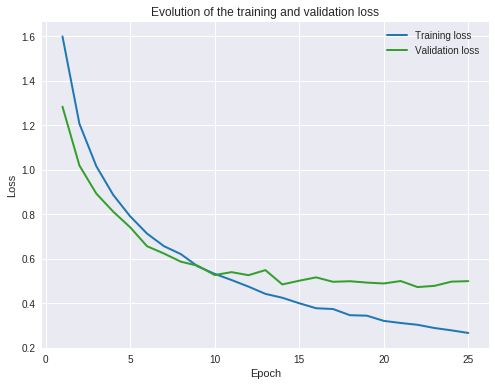

In [0]:
plot_losses(train_history, val_history)

In [0]:
compute_accuracy(net)

Accuracy of the network on the 45000 train images: 85.15 %
Accuracy of the network on the 5000 validation images: 83.96 %
Accuracy of the network on the 10000 test images: 80.47 %


In [0]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        84.63   
car          92.28   
bird         76.56   
cat          67.00   
deer         74.95   
dog          76.23   
frog         80.65   
horse        83.64   
ship         84.33   
truck        85.58   


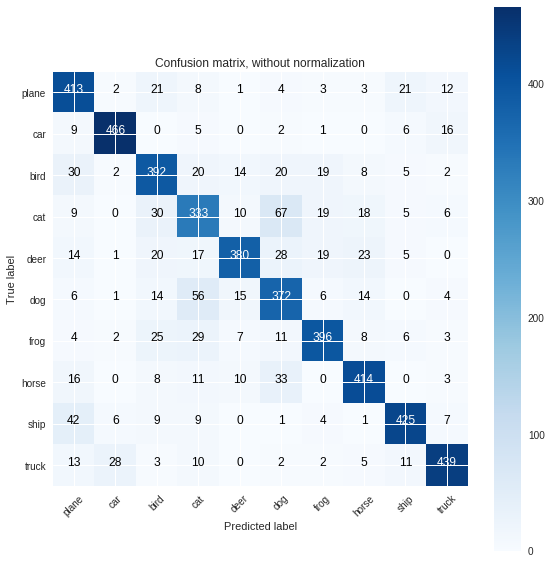

In [0]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In [0]:
from google.colab import files
torch.save(net.state_dict(), "Model2.pwf") 
files.download('Model2.pwf')

## 3. Load and test trained model

In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
tnet = MyConvolutionalNetwork2()
tnet.load_state_dict(torch.load("Model.pwf"))


In [38]:
compute_accuracy(tnet)

Accuracy of the network on the 45000 train images: 86.69 %
Accuracy of the network on the 5000 validation images: 85.04 %
Accuracy of the network on the 10000 test images: 80.78 %


In [0]:
confusion_matrix = accuracy_per_class(tnet)

In [0]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')